In [1]:
import tensorflow as tf
import sys
sys.path.append('segment')
import segment as sm
# import albumentations as A

import os
from skimage import io
import numpy as np
from sklearn.metrics import confusion_matrix

from helper_function import precision, recall, f1_score, iou_calculate

# sm.set_framework('tf.keras')
import glob
from natsort import natsorted

Segmentation Models: using `tf.keras` framework.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
model_root_dir = './trained_models/'  # model root folder

model_name = 'livedead-net-Unet-bone-efficientnetb3-pre-True-epoch-200-batch-14-lr-0.0005-banl-False-dim-512-train-900-bk-0.5-one-True' # model folder
model_folder = model_root_dir+model_name

## parse model name
backbone = 'efficientnetb3'
val_dim = 832   # input image dimension dim x dim x 3
preprocess_input = sm.get_preprocessing(backbone)
data_dir = './data'
image_dir = os.path.join(data_dir, 'images'); map_dir = os.path.join(data_dir, 'gt_maps')
image_fns = os.listdir(image_dir)
images = []; gt_maps = []
for img_fn in image_fns:
	image = io.imread(image_dir+'/{}'.format(img_fn)); images.append(image)
	gt_map =  io.imread(map_dir+'/{}'.format(img_fn)); gt_maps.append(gt_map)
images = np.stack(images); gt_maps = np.stack(gt_maps)
images = preprocess_input(images); #gt_maps = preprocess_input(gt_maps)

In [3]:
print(gt_maps.shape)

(10, 832, 832)


In [9]:
import matplotlib.pyplot as plt
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    SMALL_SIZE = 24
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 24

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    return fig, ax

In [6]:
if os.path.exists(model_folder+'/ready_model.h5'):
	model=tf.keras.models.load_model(model_folder+'/ready_model.h5')

In [12]:
pr_masks = model.predict(images); ## live, intermediate, dead, background
pr_maps = np.argmax(pr_masks,axis=-1)

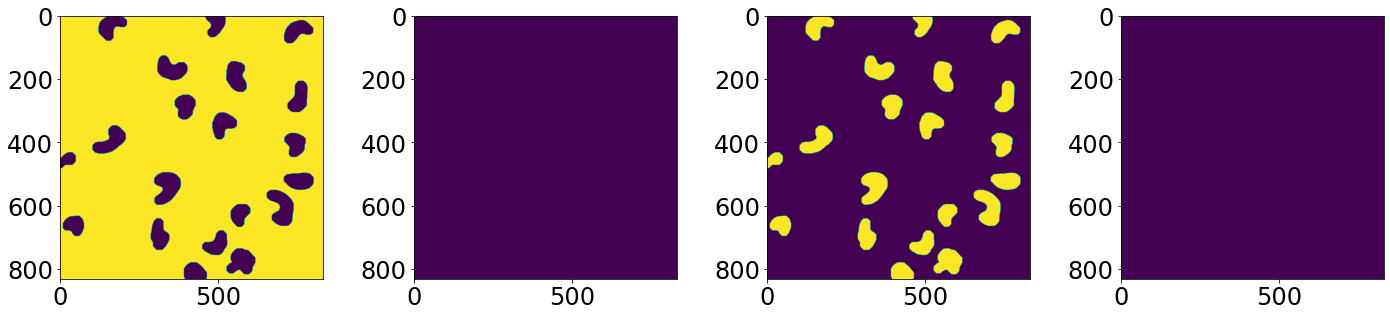

In [16]:
_, ax = get_ax(1,4,5)
gt_map = gt_maps[0,:]
ax[0].imshow(gt_map ==0); ax[1].imshow(gt_map==1); ax[2].imshow(gt_map==2); ax[3].imshow(gt_map==3)

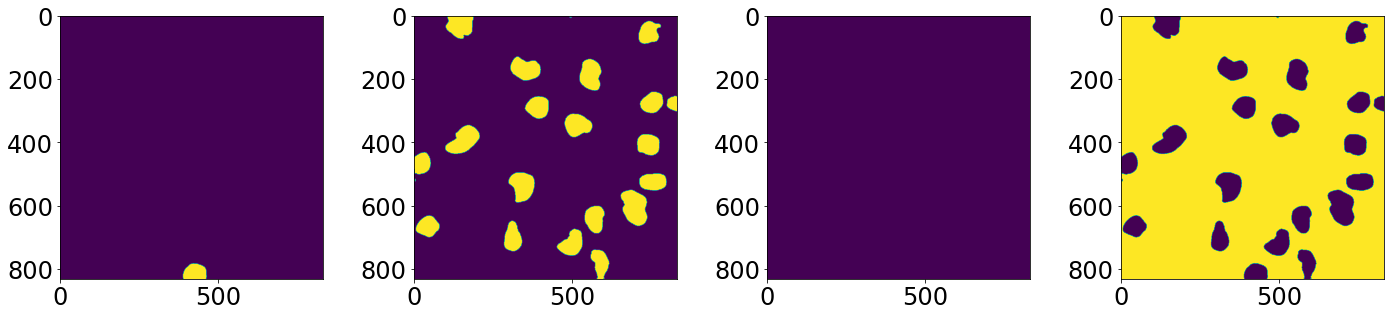

In [15]:
_, ax = get_ax(1,4,5)
pr_map = pr_maps[0,:,:]
ax[0].imshow(pr_map ==0); ax[1].imshow(pr_map==1); ax[2].imshow(pr_map==2); ax[3].imshow(pr_map==3)

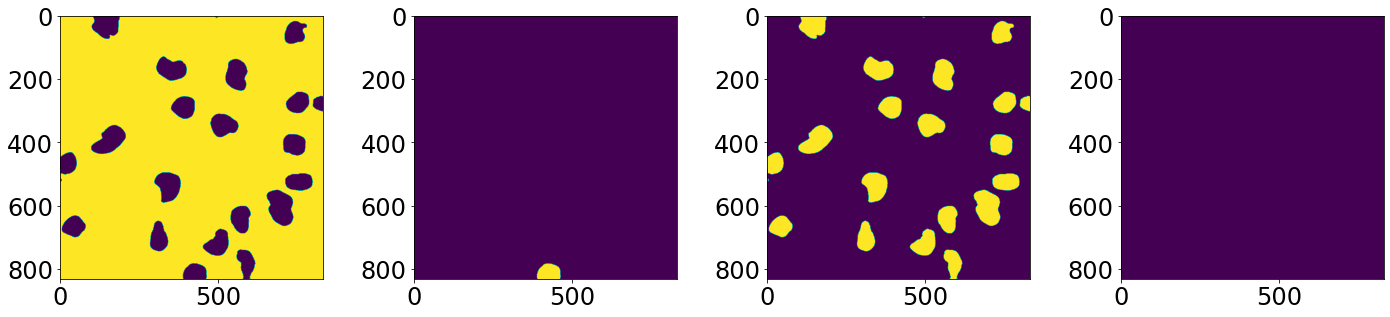

In [23]:
_, ax = get_ax(1,4,5)
pr_masks = model.predict(images); ## probability maps [N(num of images) x H x W x C(class)] for live, intermediate, dead, background 
pr_masks_ = np.zeros(pr_masks.shape, dtype = np.float32)
pr_masks_[:,:,:,0] = pr_masks[:,:,:,3]; pr_masks_[:,:,:,1:]= pr_masks[:,:,:,:3]
# pr_masks_list = [pr_masks[:,:,:,v] for v in [3,0,1,2]]
# pr_masks= np.stack(pr_masks_list, axis = -1) ## background, live, intermediate, dead
pr_maps = np.argmax(pr_masks_,axis=-1)
pr_map = pr_maps[0,:,:]
ax[0].imshow(pr_map ==0); ax[1].imshow(pr_map==1); ax[2].imshow(pr_map==2); ax[3].imshow(pr_map==3)